Elastic Net Regression

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as MSE

Implementation

In [ ]:
def add_b0_coef(X: np.ndarray) -> np.ndarray:
  '''
  Add a column for intercept calculation.
  '''
  ones = np.ones((X.shape[0], 1))
  return np.hstack((ones, X))

def elastic_net(X: np.ndarray, Y: np.ndarray, alpha: float, l1_ratio: float, lr: float, iters: int) -> np.array:
  '''
  Calculate coefficients of the Elastic Net Regression with gradient descent.

  Parameters:
  X (np.ndarray) : Train data.
  Y (np.ndarray) : Target values.
  alpha (float) : Constant that multiplies the penalty terms.
  l1_ratio (float) : Ratio of L1 penalty.
  lr (float) : Learning rate.
  iters (int) : Number of iterations.

  Returns:
  np.ndarray : Regression coefficients.
  '''

  random.seed(26)

  # initilize beta randomly
  B = np.random.rand(X.shape[1], 1)

  for _ in range(iters):
    # get predictions
    Y_pred = predict(X, B)
    Y_pred = np.reshape(Y_pred, (Y_pred.shape[0], 1))

    # calculate gradients in respect to beta
    coeff_grad = -2 * (X.T @ (Y - Y_pred))/(X.shape[0])
    l1_grad = l1_ratio * np.sign(B)
    l2_grad = (1 - l1_ratio) * B

    total_grad = coeff_grad + alpha * (l1_grad + l2_grad)

    # new beta
    B =  B - lr * total_grad

  return B

def predict(X: np.ndarray, B: np.ndarray) -> np.ndarray:
  '''
  Predict target values.
  '''
  return X @ B

def mean_squared_error(Y_pred: np.ndarray, Y: np.ndarray) -> np.ndarray:
  '''
  Calculate Mean Squared Error.
  '''
  return sum((Y - Y_pred)**2)/len(Y)

def elastic_net_cost(Y_pred: np.ndarray, Y: np.ndarray, B: np.ndarray, alpha: float, l1_ratio: float) -> float:
  '''
  Calculate cost function for Elastic Net Regression.
  '''
  mse = mean_squared_error(Y_pred, Y)

  return mse +  alpha * (l1_ratio * sum(np.abs(B)) + ((1 - l1_ratio) / 2) * np.sqrt(np.sum(B**2)))

def R_squared(Y: np.ndarray, Y_pred: np.ndarray) -> np.ndarray:
  '''
  Calculate coefficent of determination.
  '''
  nominator = sum(Y - Y_pred)**2
  denominator = sum(Y - np.mean(Y, axis=0))

  return 1 - nominator/denominator


Testing implementation on the sklearn diabetes dataset.


In [ ]:
data = load_diabetes()

In [ ]:
# add a column of ones
X = add_b0_coef(data.data)

# target value
Y = data.target.reshape(442,1)

# lasso regression with gradient descent
B = elastic_net(X, Y, alpha=0.1, l1_ratio=0.1, lr=0.1, iters=10000)

# get predictions
Y_pred = predict(X, B)
Y_pred = np.reshape(Y_pred, (Y_pred.shape[0], 1))

# get metrics
my_cost = elastic_net_cost(Y_pred, data.target, B, 0.1, 0.1)
my_mse = mean_squared_error(Y_pred, data.target.reshape(442,1))
my_r_squared = R_squared(data.target, Y_pred)

Now, running the regression with the default sklearn ElasticNet Regression, for comparison.

In [ ]:
# instantiate model
model = ElasticNet(alpha=0.1, l1_ratio=0.1)

# get solution
model.fit(X, data.target)

# get predictions
y_pred = model.predict(X)

# obtain metrics
mse = MSE(data.target, y_pred)
r_squared = R_squared(data.target, y_pred)

Finally, comparing results:

In [ ]:
print(f'My MSE: {my_mse[0]:.2f}, sklearn MSE: {mse:.2f}')
print(f'My Intercept: {B[0, 0]:.2f}, sklearn Intercept: {model.intercept_:.2f}')
formatted= [f'{c:.2f}' for c in model.coef_[1:]]
my_formatted = [f'{c:.2f}' for c in B[1:, 0]]
print(f'My Coefficients: {my_formatted}, \nsklearn Coefficients: {formatted}')

My MSE: 5291.34, sklearn MSE: 5549.29
My Intercept: 145.58, sklearn Intercept: 152.13
My Coefficients: ['12.05', '1.02', '41.99', '31.06', '12.83', '9.77', '-27.26', '28.61', '39.70', '25.84'], 
sklearn Coefficients: ['6.68', '0.99', '22.24', '16.57', '7.33', '5.79', '-14.67', '15.69', '21.23', '14.05']


Accurate implementation.

Now, executing a K-Fold train/test in search of the best possible value for the L1 factor $l1\_ratio$ and the best penalty factor $\alpha$.

In [ ]:
# target values
Y = data.target.reshape(442,1)

# alphas to test
possible_alphas = np.arange(0.00, 2.50, 0.5)
possible_ratios = np.arange(0.00, 1.02, 0.02)

# set kfold
kf = KFold(n_splits=5, shuffle=True, random_state=26)

# set lines and columns size
m = len(possible_alphas)
n = len(possible_ratios)

# set auxiliary variables
mean_mse_list = np.zeros((m, n))
mean_cost_list = np.zeros((m, n))

i = 0
for alpha_ in possible_alphas:
  j = 0
  for l1_ratio_ in possible_ratios:
    mse_list = []
    cost_list = []
    for train_index, test_index in kf.split(X):
      # separate train/test split
      X_train = X[train_index]
      Y_train = Y[train_index]

      X_test = X[test_index]
      Y_test = Y[test_index]

      # calculate solution
      B = elastic_net(X_train, Y_train, alpha=alpha_, l1_ratio=l1_ratio_, lr=0.1, iters=1000)

      # get predictions
      Y_pred = predict(X_test, B)

      # get metrics
      cost = elastic_net_cost(Y_pred, Y_test, B, alpha=alpha_, l1_ratio=l1_ratio_)
      mse = mean_squared_error(Y_pred, Y_test)

      mse_list.append(mse)
      cost_list.append(cost)

    # get mean of all folds
    mean_mse_list[i][j] = np.mean(mse_list)
    mean_cost_list[i][j] = np.mean(cost_list)
    j += 1
  i += 1


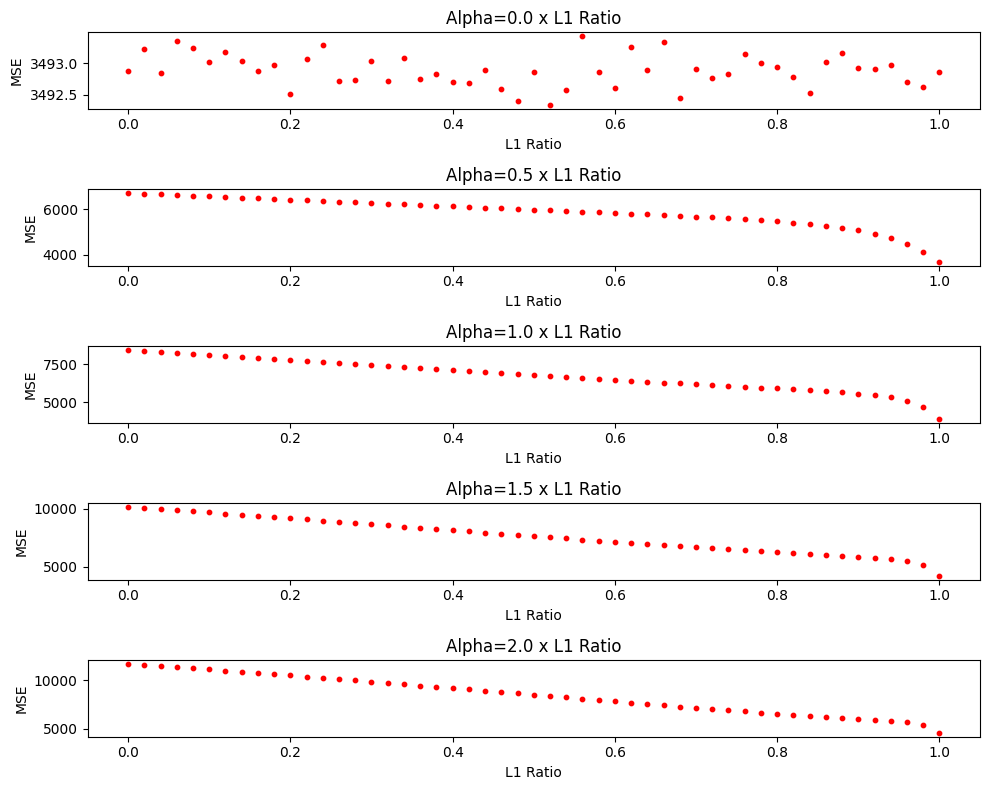

In [ ]:
# plot results
fig, ax = plt.subplots(m, 1, figsize=(10, 8))
for j in range(m):
  ax[j].scatter(possible_ratios, mean_mse_list[j, :], c='r', s=10)
  ax[j].set_xlabel('L1 Ratio')
  ax[j].set_ylabel('MSE')
  ax[j].set_title(f'Alpha={possible_alphas[j]} x L1 Ratio')
plt.tight_layout()
plt.show()


The results indicate that the regression model with the best test performance on the data is the Linear Regression ($\alpha=0$). In all cases of testing ElasticNet with different alphas ($\alpha>0$), the best performance occurred when the L1 Ratio was set to one, which is equivalent to Lasso Regression. This suggests potential multicollinearity among the features. Since Lasso Regression can set some regression coefficients to zero, unlike Ridge Regression, which simultaneously reduces coefficients but never to absolute zero, this experiment shows that a sparse model is better suited for explaining the diabetes distribution function.